# UNet model

Running the UNet from here 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import skorch
import torchvision.datasets as dset
import torchvision.models as models
import collections
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision.transforms as transforms
from tqdm import tqdm

%matplotlib inline

from optparse import OptionParser
from unet import UNet
from utils import *
from myloss import dice_coeff

from skimage.filters import threshold_otsu, rank

import numpy as np
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
from UNet_Loader import ILDDataset

/home/CharlesAkin-David/cs231n_bmi260_project/Pytorch-UNet/utils/data_vis.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in sta

In [3]:
NUM_TOTAL = 830
NUM_TRAIN = 700

lung_dataset_train = ILDDataset(cystic_path='../Cyst_Dataset/Cystic_masks_new/Train',
                          root_dir='../Cyst_Dataset/Train',
                          mask=True, HU=True, resize=512)

lung_dataset_test = ILDDataset(cystic_path='../Cyst_Dataset/Cystic_masks_new/Test',
                          root_dir='../Cyst_Dataset/Test',
                          mask=True, HU=True, resize=512)

loader_train = DataLoader(lung_dataset_train, batch_size=4, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(lung_dataset_train, batch_size=4, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTAL)))

loader_test = DataLoader(lung_dataset_test, batch_size=4)

In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Check Accuracy

In [5]:
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    
    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [9]:
def eval_net(net, loader, device, gpu=True):
    if loader.dataset.train:
        print('Checking accuracy on training set')
    else:
        print('Checking accuracy on test set')   

    tot = 0
    cntr = 0
    net.eval()
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            if gpu:
                net.cuda()
                X = Variable(X, requires_grad=True).cuda()
                y = Variable(y, requires_grad=True).cuda()
            else:
                X = Variable(X, requires_grad=True)
                y = Variable(y, requires_grad=True)

            X.unsqueeze_(1)
            y.unsqueeze_(1)
            y_pred = net(X)

#             y_pred = (F.sigmoid(y_pred) > 0.5).float()
#             dice = dice_coeff(y_pred, y.float()).data[0]
            probs = F.sigmoid(y_pred)
            thresh = threshold_otsu(probs.data.cpu().numpy())
            y_pred_print = (probs > thresh)
            dice = dice_loss(y_pred_print.float(), y)
            tot += dice
            cntr += 1
            
            if 0:
                X = X.data.squeeze(1).cpu().numpy()
                print('X', X.shape)
                X = np.transpose(X, axes=[1, 2, 0])
                print('X.T', X.shape)
                y = y.data.squeeze(1).cpu().numpy()
                print('y', y.shape)
                y = np.transpose(y, axes=[1, 2, 0])
                print('y.T', y.shape)
                y_pred = y_pred.data.squeeze(1).squeeze(1).cpu().numpy()
                y_pred = np.transpose(y_pred, axes=[1, 2, 0])
                print(y_pred.shape)

                fig = plt.figure()
                ax1 = fig.add_subplot(1, 4, 1)
                ax1.imshow(X)
                ax2 = fig.add_subplot(1, 4, 2)
                ax2.imshow(y)
                ax3 = fig.add_subplot(1, 4, 3)
                ax3.imshow((y_pred > 0.5))
                
                y_pred = np.transpose(y_pred, axes=[2, 0, 1])
                Q = dense_crf(((X[0] * 255).round()).astype(np.uint8), y_pred[0])
                ax4 = fig.add_subplot(1, 4, 4)
                print(Q)
                ax4.imshow(Q > 0.5)
                plt.show()
    return tot / cntr

# Train

In [14]:
#Train function

def train_net(net, epochs=50, batch_size=4, lr=1e-3, save=True, gpu=True):
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    criterion = nn.BCELoss()
    dir_checkpoint = 'checkpoints/'
    
    all_losses = []
    for epoch in range(epochs):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))

        epoch_loss = 0
            
        for t, (X, y) in enumerate(loader_train):
            X = X.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            X.unsqueeze_(1)
            y.unsqueeze_(1)

            if gpu:
                net.cuda()
                X = Variable(X).cuda()
                y = Variable(y).cuda()
            else:
                X = Variable(X)
                y = Variable(y)
            
            
            y_pred = net(X)
#             print(y_pred.shape)
            
            probs = F.sigmoid(y_pred)
            thresh = threshold_otsu(probs.data.cpu().numpy())
            probs_flat = probs.view(-1)
            y_pred_print = (probs > thresh)
            y_flat = y.view(-1)

            loss = criterion(probs_flat, y_flat.float())
            all_losses.append(loss)
            epoch_loss += loss.data[0]

            if(t%100 == 0):
                print('{0:.4f} --- loss: {1:.6f}'.format(t,
                                                     loss.data[0]))
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
                
        print('Epoch finished ! Loss: {}'.format(epoch_loss / t))
        
        if 1:
            val_dice = eval_net(net, loader_val, device, gpu)
            print('Validation Dice Coeff: {}'.format(val_dice))
            
            print("X")
            plt.imshow(X.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Predicted Y")
            plt.imshow(y_pred.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Probs Y")
            plt.imshow(probs.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Print Y")
            plt.imshow(y_pred_print.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Actual Y")
            plt.imshow(y.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
#             _ = plt.hist(probs.data.cpu().numpy().reshape([-1]), 1000)
#             plt.ylim([0, 500])
#             plt.plot([thresh, thresh], [0, 500], 'r')
#             plt.show()

        if save:
            torch.save(net.state_dict(),
                       dir_checkpoint + '/batch_4/CP{}.pth'.format(epoch + 79))

            print('Checkpoint {} saved !'.format(epoch + 1))
            
    return all_losses


Starting epoch 1/50.
0.0000 --- loss: 0.118135
100.0000 --- loss: 0.054345
Epoch finished ! Loss: 0.07261177152395248
Checking accuracy on test set
Validation Dice Coeff: 0.04788147658109665
X


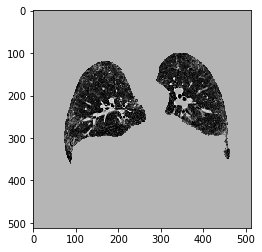

Predicted Y


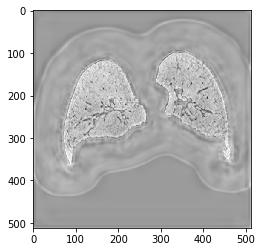

Probs Y


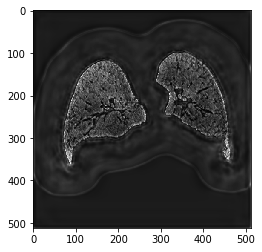

Print Y


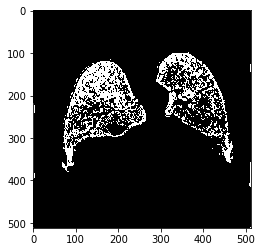

Actual Y


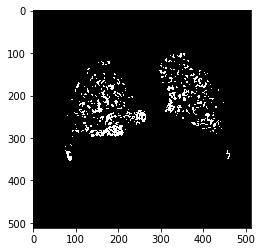

Checkpoint 1 saved !
Starting epoch 2/50.
0.0000 --- loss: 0.038957
100.0000 --- loss: 0.010572
Epoch finished ! Loss: 0.021115371957421303
Checking accuracy on test set
Validation Dice Coeff: 0.08108197152614594
X


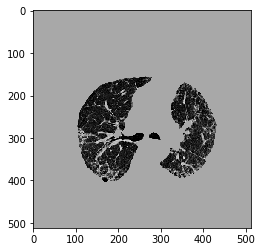

Predicted Y


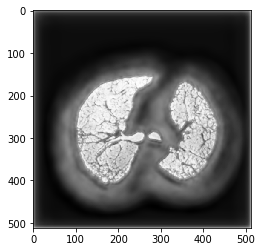

Probs Y


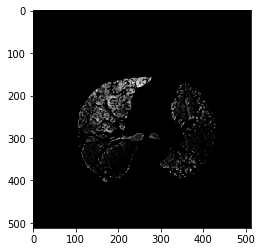

Print Y


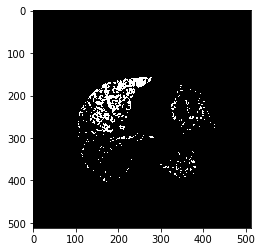

Actual Y


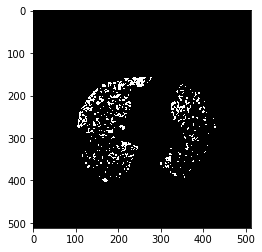

Checkpoint 2 saved !
Starting epoch 3/50.
0.0000 --- loss: 0.005077
100.0000 --- loss: 0.053976
Epoch finished ! Loss: 0.01648685894906521
Checking accuracy on test set
Validation Dice Coeff: 0.17961768805980682
X


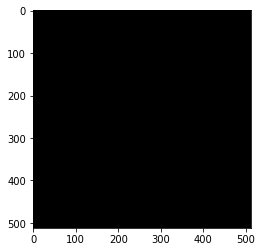

Predicted Y


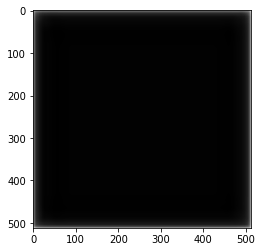

Probs Y


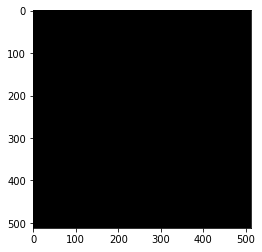

Print Y


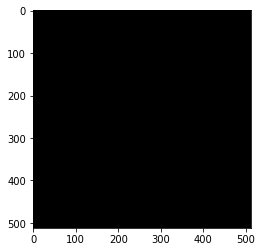

Actual Y


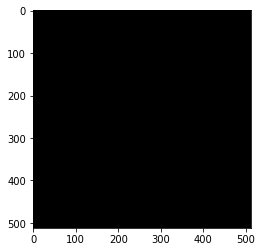

Checkpoint 3 saved !
Starting epoch 4/50.
0.0000 --- loss: 0.003019
100.0000 --- loss: 0.000568
Epoch finished ! Loss: 0.016982311382889748
Checking accuracy on test set
Validation Dice Coeff: 0.010403075255453587
X


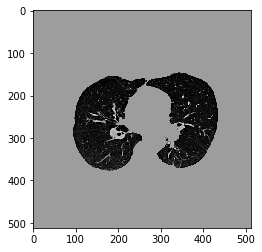

Predicted Y


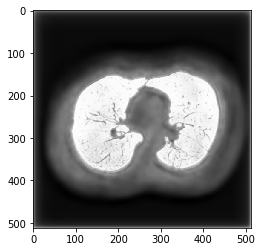

Probs Y


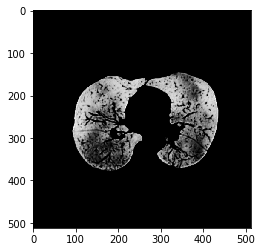

Print Y


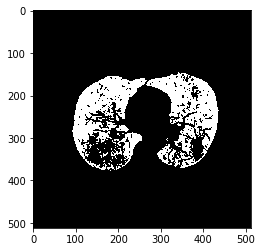

Actual Y


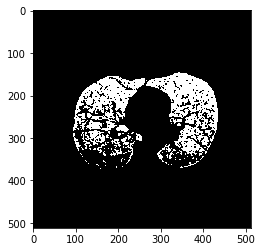

Checkpoint 4 saved !
Starting epoch 5/50.
0.0000 --- loss: 0.021937
100.0000 --- loss: 0.015477
Epoch finished ! Loss: 0.017171485349535942
Checking accuracy on test set
Validation Dice Coeff: 0.16146089136600494
X


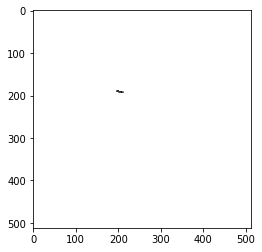

Predicted Y


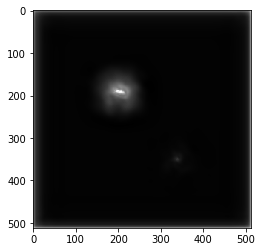

Probs Y


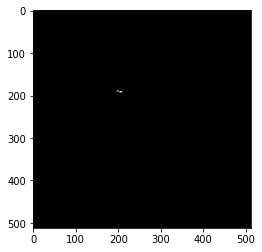

Print Y


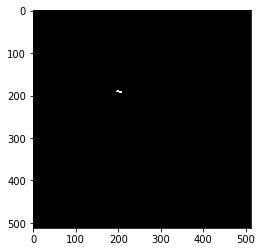

Actual Y


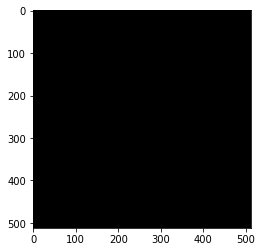

Checkpoint 5 saved !
Starting epoch 6/50.
0.0000 --- loss: 0.004731
100.0000 --- loss: 0.016018
Epoch finished ! Loss: 0.015583512373268604
Checking accuracy on test set
Validation Dice Coeff: 0.12055903673171997
X


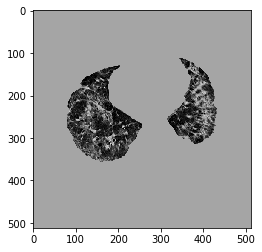

Predicted Y


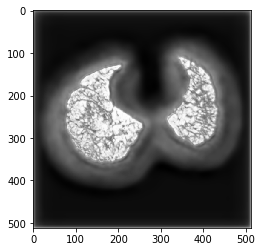

Probs Y


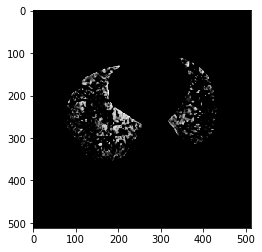

Print Y


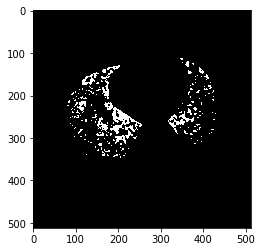

Actual Y


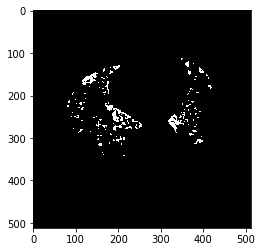

Checkpoint 6 saved !
Starting epoch 7/50.
0.0000 --- loss: 0.005701
100.0000 --- loss: 0.008766
Epoch finished ! Loss: 0.015157428570091724
Checking accuracy on test set
Validation Dice Coeff: 0.2603495717048645
X


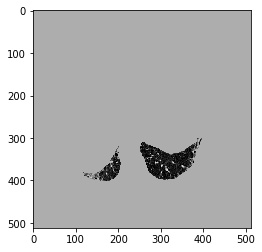

Predicted Y


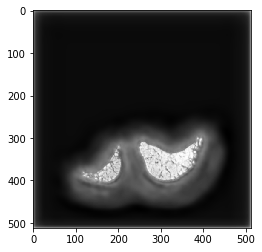

Probs Y


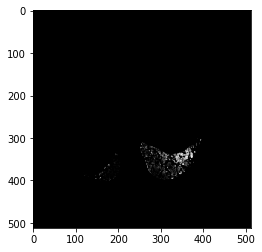

Print Y


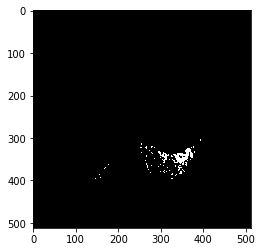

Actual Y


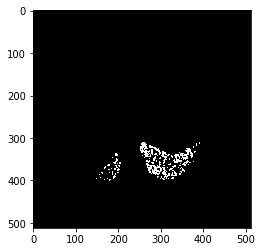

Checkpoint 7 saved !
Starting epoch 8/50.
0.0000 --- loss: 0.053379
100.0000 --- loss: 0.047768
Epoch finished ! Loss: 0.0149551872164011
Checking accuracy on test set
Validation Dice Coeff: 0.25802329182624817
X


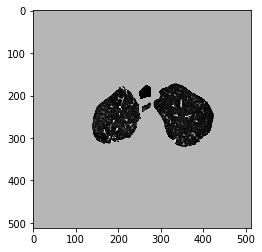

Predicted Y


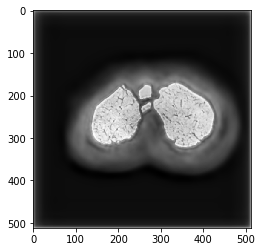

Probs Y


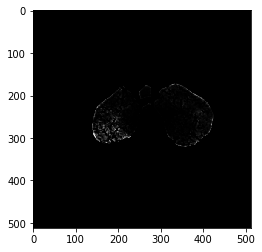

Print Y


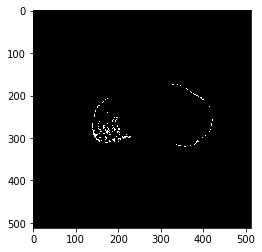

Actual Y


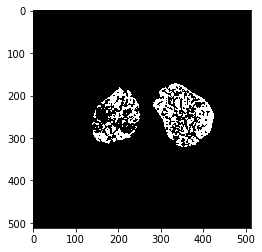

Checkpoint 8 saved !
Starting epoch 9/50.
0.0000 --- loss: 0.025612
100.0000 --- loss: 0.008994
Epoch finished ! Loss: 0.015642551705241203
Checking accuracy on test set
Validation Dice Coeff: 0.11544344574213028
X


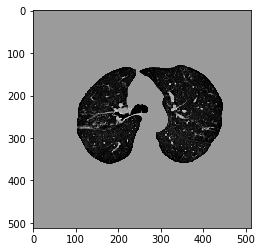

Predicted Y


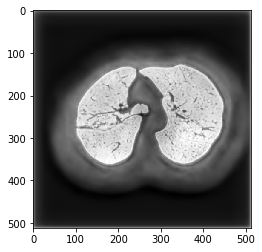

Probs Y


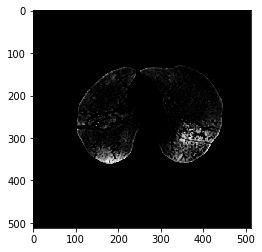

Print Y


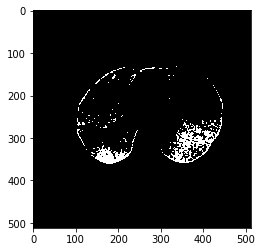

Actual Y


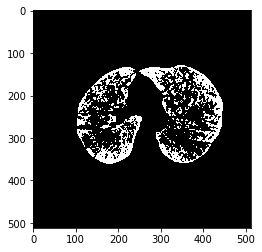

Checkpoint 9 saved !
Starting epoch 10/50.
0.0000 --- loss: 0.006028
100.0000 --- loss: 0.001364
Epoch finished ! Loss: 0.017528098076581955
Checking accuracy on test set
Validation Dice Coeff: 0.07929437607526779
X


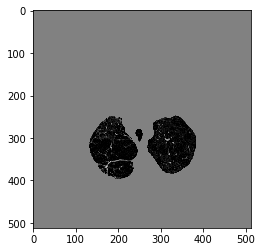

Predicted Y


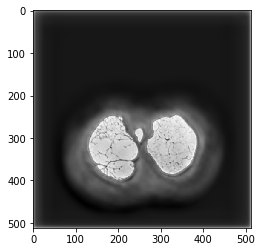

Probs Y


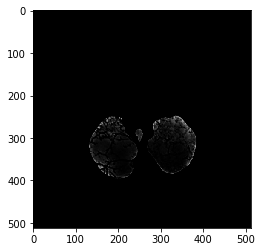

Print Y


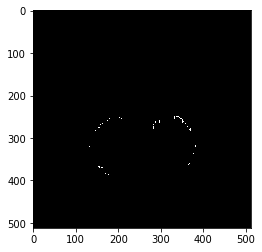

Actual Y


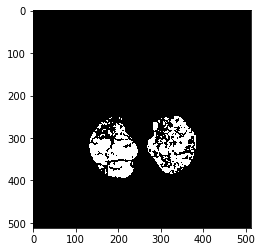

Checkpoint 10 saved !
Starting epoch 11/50.
0.0000 --- loss: 0.007284
100.0000 --- loss: 0.023874
Epoch finished ! Loss: 0.01520360354334116
Checking accuracy on test set
Validation Dice Coeff: 0.08411690592765808
X


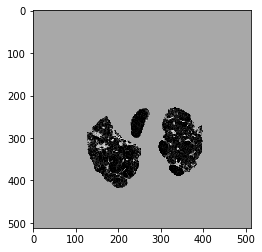

Predicted Y


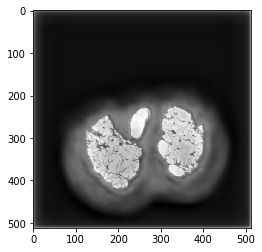

Probs Y


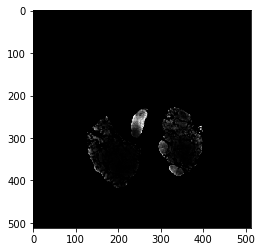

Print Y


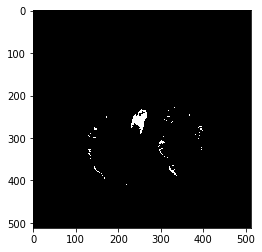

Actual Y


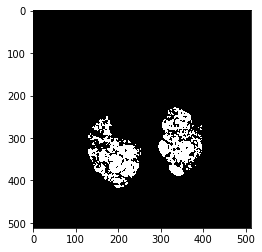

Checkpoint 11 saved !
Starting epoch 12/50.
0.0000 --- loss: 0.032096
100.0000 --- loss: 0.025836
Epoch finished ! Loss: 0.013894102536141872
Checking accuracy on test set
Validation Dice Coeff: 0.1554575264453888
X


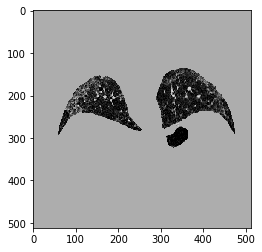

Predicted Y


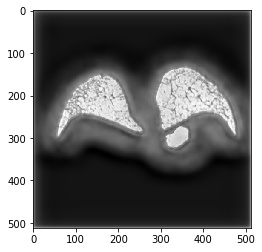

Probs Y


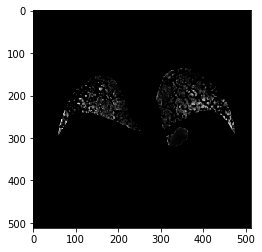

Print Y


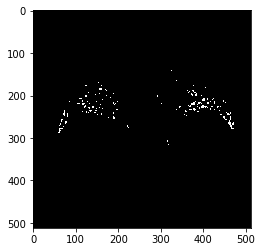

Actual Y


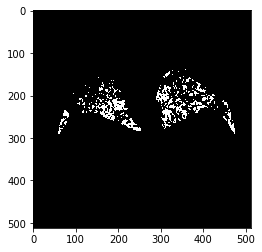

Checkpoint 12 saved !
Starting epoch 13/50.
0.0000 --- loss: 0.020728
100.0000 --- loss: 0.006356
Epoch finished ! Loss: 0.013501609675586224
Checking accuracy on test set
Validation Dice Coeff: 0.1356825828552246
X


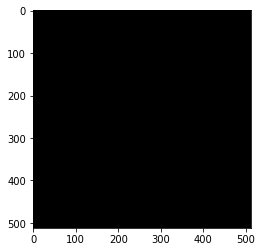

Predicted Y


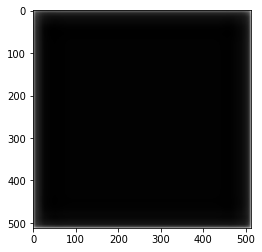

Probs Y


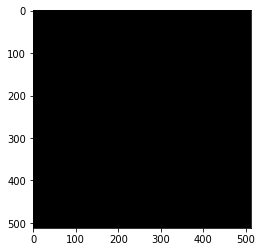

Print Y


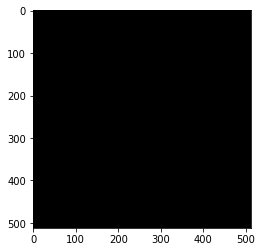

Actual Y


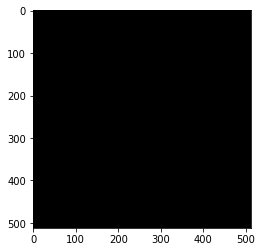

Checkpoint 13 saved !
Starting epoch 14/50.
0.0000 --- loss: 0.037445
100.0000 --- loss: 0.010444
Epoch finished ! Loss: 0.01318221352994442
Checking accuracy on test set
Validation Dice Coeff: 0.18722601234912872
X


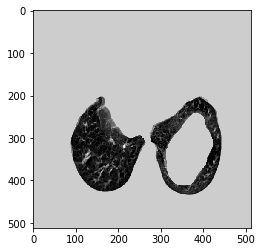

Predicted Y


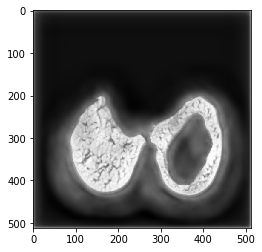

Probs Y


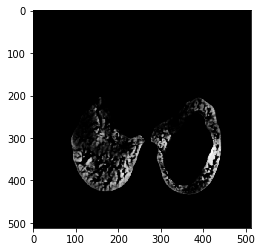

Print Y


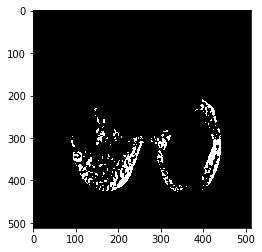

Actual Y


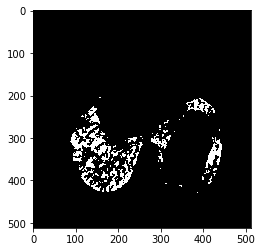

Checkpoint 14 saved !
Starting epoch 15/50.
0.0000 --- loss: 0.005471
100.0000 --- loss: 0.051123
Epoch finished ! Loss: 0.013202178291976452
Checking accuracy on test set
Validation Dice Coeff: 0.20650508999824524
X


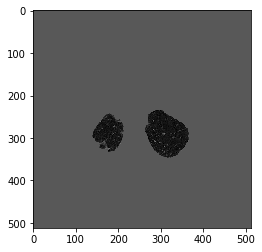

Predicted Y


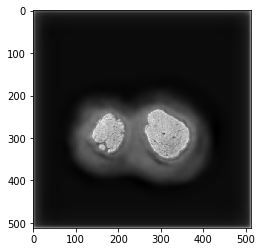

Probs Y


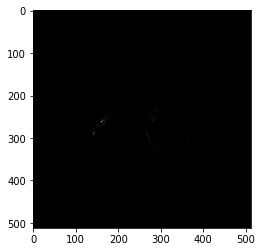

Print Y


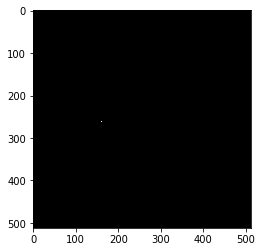

Actual Y


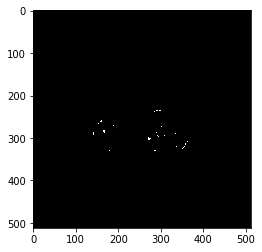

Checkpoint 15 saved !
Starting epoch 16/50.
0.0000 --- loss: 0.003578
100.0000 --- loss: 0.001778
Epoch finished ! Loss: 0.011842031963169575
Checking accuracy on test set
Validation Dice Coeff: 0.3898063600063324
X


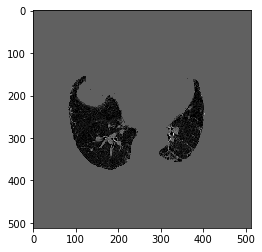

Predicted Y


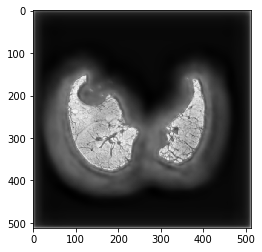

Probs Y


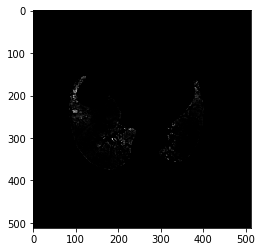

Print Y


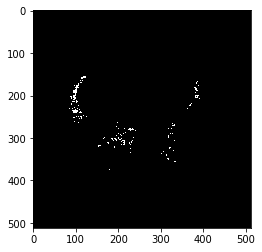

Actual Y


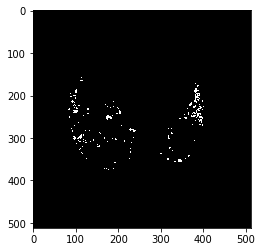

Checkpoint 16 saved !
Starting epoch 17/50.
0.0000 --- loss: 0.025422
100.0000 --- loss: 0.030290
Epoch finished ! Loss: 0.01484768558293581
Checking accuracy on test set
Validation Dice Coeff: 0.21688584983348846
X


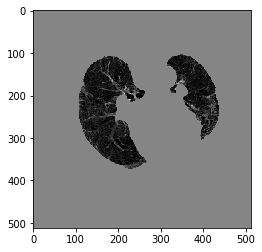

Predicted Y


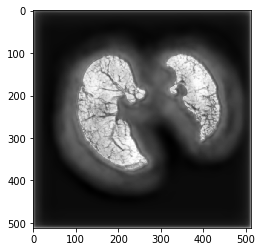

Probs Y


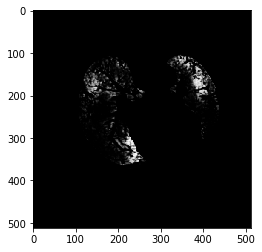

Print Y


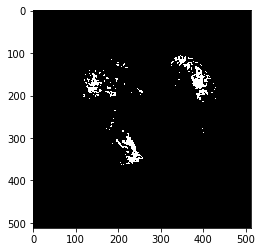

Actual Y


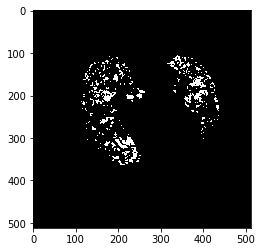

Checkpoint 17 saved !
Starting epoch 18/50.
0.0000 --- loss: 0.024431
100.0000 --- loss: 0.001608
Epoch finished ! Loss: 0.01114891842007637
Checking accuracy on test set
Validation Dice Coeff: 0.3057674765586853
X


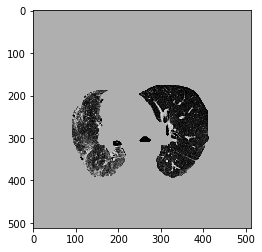

Predicted Y


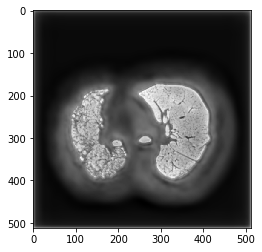

Probs Y


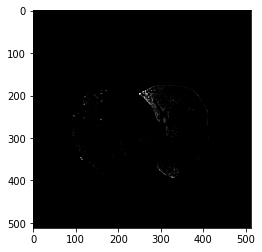

Print Y


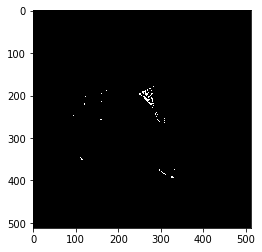

Actual Y


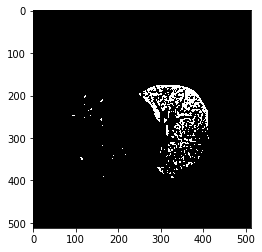

Checkpoint 18 saved !
Starting epoch 19/50.
0.0000 --- loss: 0.001054
100.0000 --- loss: 0.003242
Epoch finished ! Loss: 0.012910048477351665
Checking accuracy on test set
Validation Dice Coeff: 0.287707656621933
X


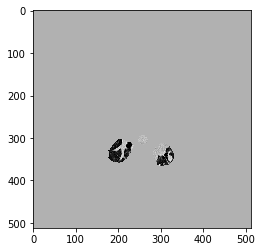

Predicted Y


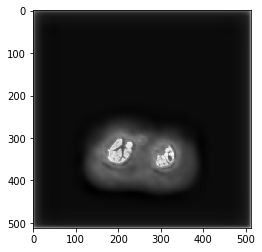

Probs Y


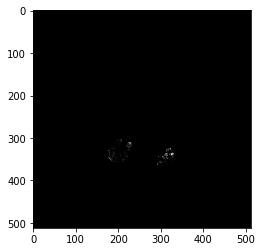

Print Y


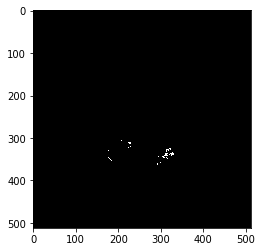

Actual Y


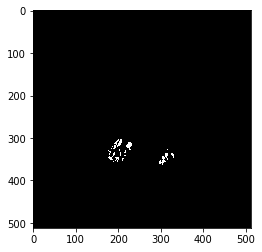

Checkpoint 19 saved !
Starting epoch 20/50.
0.0000 --- loss: 0.008428
100.0000 --- loss: 0.000506
Epoch finished ! Loss: 0.01006201934069395
Checking accuracy on test set
Validation Dice Coeff: 0.2721717953681946
X


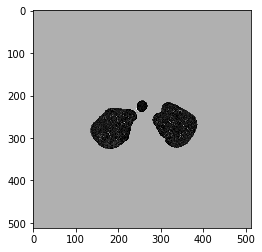

Predicted Y


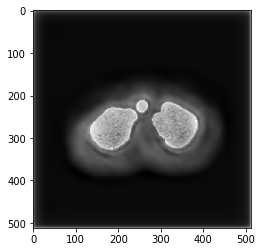

Probs Y


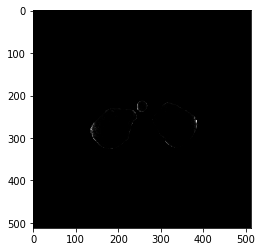

Print Y


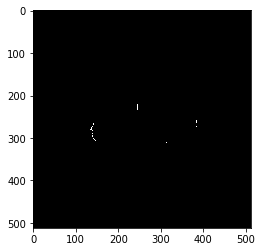

Actual Y


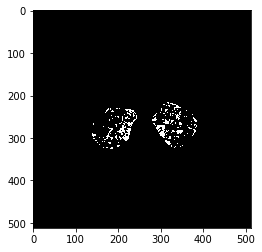

Checkpoint 20 saved !
Starting epoch 21/50.
0.0000 --- loss: 0.002461
100.0000 --- loss: 0.010508
Epoch finished ! Loss: 0.009424078278243542
Checking accuracy on test set
Validation Dice Coeff: 0.4032650291919708
X


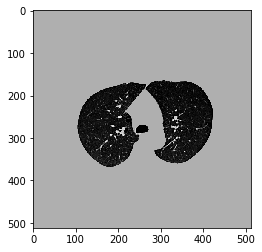

Predicted Y


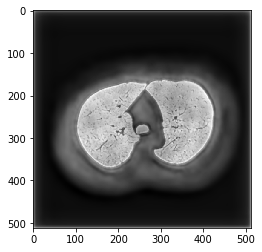

Probs Y


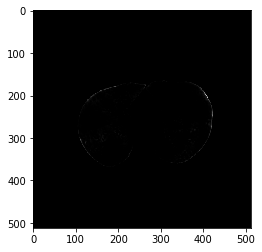

Print Y


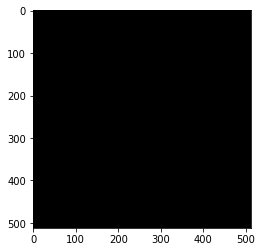

Actual Y


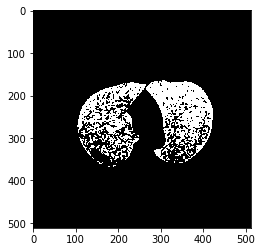

Checkpoint 21 saved !
Starting epoch 22/50.
0.0000 --- loss: 0.007569
100.0000 --- loss: 0.004647
Epoch finished ! Loss: 0.012566340155899525
Checking accuracy on test set
Validation Dice Coeff: 0.12230248004198074
X


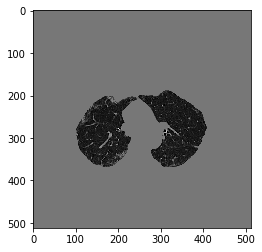

Predicted Y


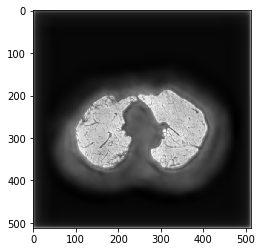

Probs Y


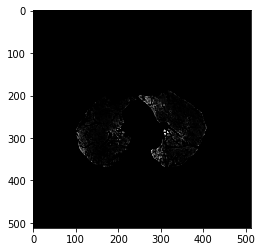

Print Y


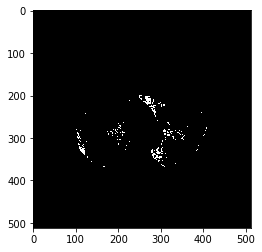

Actual Y


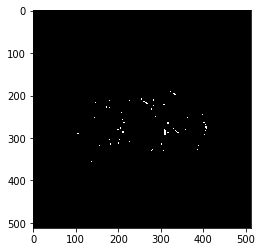

Checkpoint 22 saved !
Starting epoch 23/50.
0.0000 --- loss: 0.013629
100.0000 --- loss: 0.008909
Epoch finished ! Loss: 0.009239661507308483
Checking accuracy on test set
Validation Dice Coeff: 0.26258450746536255
X


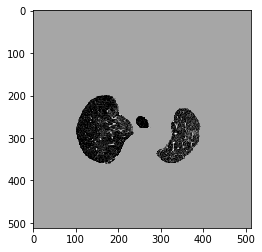

Predicted Y


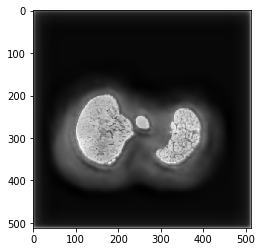

Probs Y


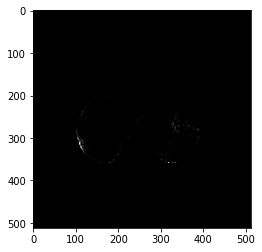

Print Y


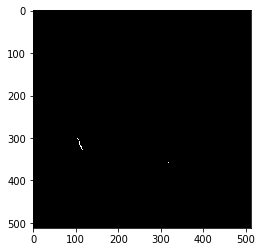

Actual Y


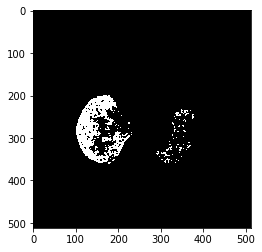

Checkpoint 23 saved !
Starting epoch 24/50.
0.0000 --- loss: 0.004212
100.0000 --- loss: 0.001580
Epoch finished ! Loss: 0.009185262024402618
Checking accuracy on test set
Validation Dice Coeff: 0.3481326997280121
X


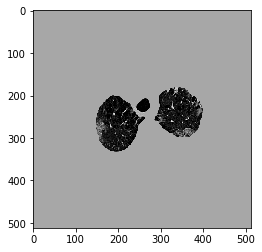

Predicted Y


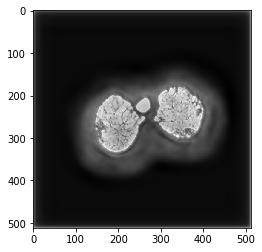

Probs Y


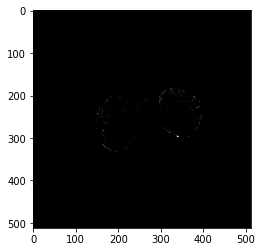

Print Y


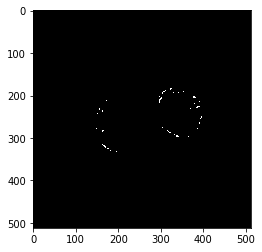

Actual Y


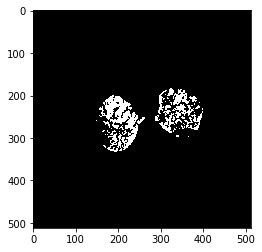

Checkpoint 24 saved !
Starting epoch 25/50.
0.0000 --- loss: 0.014178
100.0000 --- loss: 0.024780
Epoch finished ! Loss: 0.010319511406123638
Checking accuracy on test set
Validation Dice Coeff: 0.41612014174461365
X


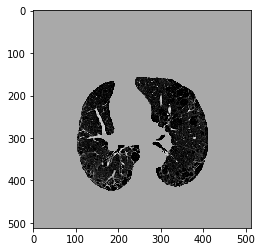

Predicted Y


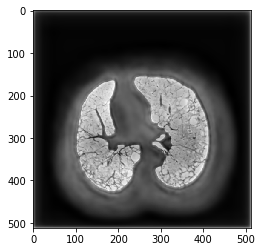

Probs Y


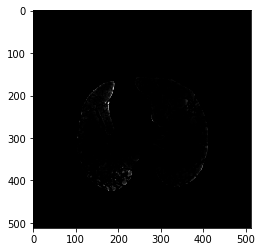

Print Y


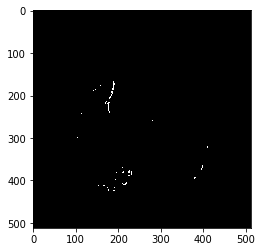

Actual Y


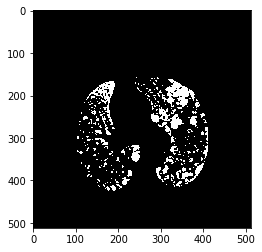

Checkpoint 25 saved !
Starting epoch 26/50.
0.0000 --- loss: 0.000526
100.0000 --- loss: 0.014177
Epoch finished ! Loss: 0.008341864682734013
Checking accuracy on test set
Validation Dice Coeff: 0.36843761801719666
X


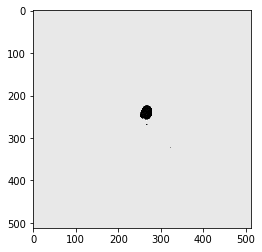

Predicted Y


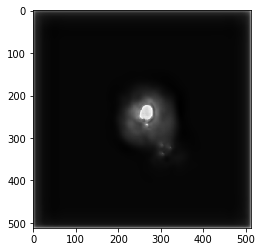

Probs Y


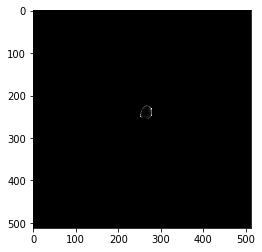

Print Y


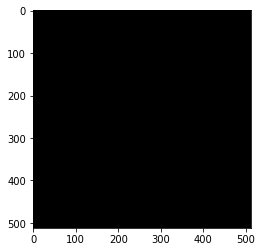

Actual Y


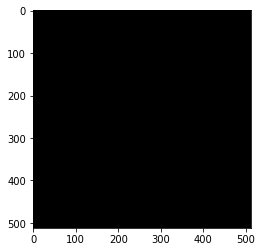

Checkpoint 26 saved !
Starting epoch 27/50.
0.0000 --- loss: 0.000502
100.0000 --- loss: 0.013475
Epoch finished ! Loss: 0.008438823744654655
Checking accuracy on test set
Validation Dice Coeff: 0.38376498222351074
X


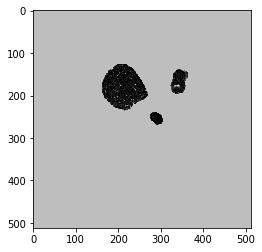

Predicted Y


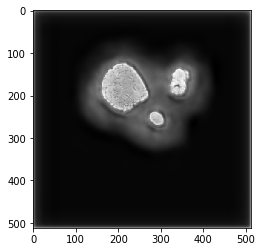

Probs Y


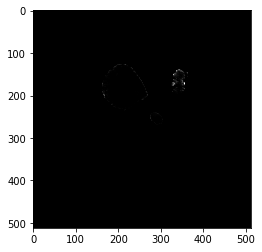

Print Y


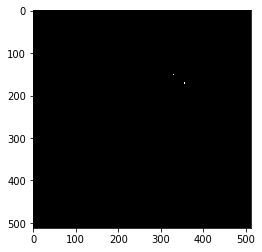

Actual Y


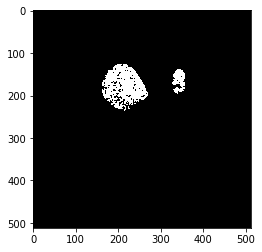

Checkpoint 27 saved !
Starting epoch 28/50.
0.0000 --- loss: 0.013117
100.0000 --- loss: 0.037365
Epoch finished ! Loss: 0.008333154954016209
Checking accuracy on test set


In [ ]:
net = UNet(1, 1)
net.load_state_dict(torch.load('checkpoints/batch_4/CP78.pth'))
try:
    all_losses = train_net(net) # , options.epochs, options.batchsize, options.lr,gpu=options.gpu)
    np.save('all_losses.pkl', all_losses)
except KeyboardInterrupt:
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    print('Saved interrupt')